# Hotel Reviews Tutorial

This tutorial uses the [Hotel-Review Datasets](https://www.cs.cmu.edu/~jiweil/html/hotel-review.html) to teach the following aspects:

* Data preparation and high-level analysis
* Langauge classification
* Sentiment analysis
* Content selection
* Review summarization using an open source language model

In [47]:
import pandas as pd
import os
import tqdm

from zipfile import ZipFile
from pandas import DataFrame
from tqdm.notebook import tqdm
from lingua import Language, LanguageDetectorBuilder
from ollama import chat
from ollama import ChatResponse

In [33]:
# Pandas options:
pd.options.mode.copy_on_write = True

## Data Preparation and Ingestion

Prepare the raw data and read it into a pandas dataframe.


In [2]:
def unzip_datafiles(zip_file_path: str):
    """
    Unzip the raw data files and set the .txt extension to .json
    :param zip_file_path: The file path to the data zip file
    """
    with ZipFile(zip_file_path) as zip_file:
        zip_file.extractall(path="./resources/data/")

    extracted_txt_file = None

    if os.name == "nt":
        extracted_txt_file = zip_file_path.split("\\")[-1]
    else:
        extracted_txt_file = zip_file_path.split("/")[-1]

    extracted_txt_file = extracted_txt_file.replace(".zip", "")

    if os.path.exists(f"./resources/data/{extracted_txt_file}"):
        # Rename file extension:
        os.rename(f"./resources/data/{extracted_txt_file}", f"./resources/data/{extracted_txt_file.replace('.txt', '.json')}")


In [3]:
# Process zip files:
unzip_datafiles("./resources/data/offering.txt.zip")
unzip_datafiles("./resources/data/review.txt.zip")

In [4]:
# Read the Accommodation dataset:
accommodation_offerings_df = pd.read_json(path_or_buf="./resources/data/offering.json", lines=True)
accommodation_offerings_df = accommodation_offerings_df[["id", "name", "type", "hotel_class", "address"]]
accommodation_offerings_df.head()

,id,name,type,hotel_class,address
0,113317,Casablanca Hotel Times Square,hotel,4.0,"{'region': 'NY', 'street-address': '147 West 4..."
1,76049,Four Seasons Hotel Los Angeles at Beverly Hills,hotel,5.0,"{'region': 'CA', 'street-address': '300 S Dohe..."
2,99352,Hilton Garden Inn Times Square,hotel,3.5,"{'region': 'NY', 'street-address': '790 Eighth..."
3,93589,The Michelangelo Hotel,hotel,4.0,"{'region': 'NY', 'street-address': '152 West 5..."
4,217616,The Muse Hotel New York,hotel,4.0,"{'region': 'NY', 'street-address': '130 West 4..."


In [5]:
# Are we only dealing with Hotels?
hotel_count = len(accommodation_offerings_df.loc[accommodation_offerings_df["type"] == "hotel"])
print(f"Only accommodations are hotels? {hotel_count == len(accommodation_offerings_df)}")

Only accommodations are hotels? True


In [6]:
# Replace any hotels without a class rating as zero:
accommodation_offerings_df.fillna({"hotel_class": 0}, inplace=True)

<Axes: title={'center': 'Hotel Class Types'}, xlabel='hotel_class'>

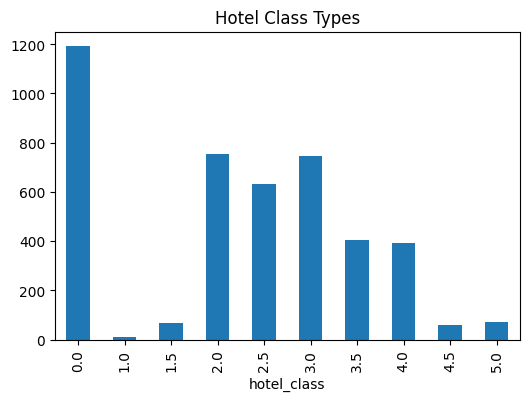

In [7]:
# Plot distribution of Hotel class types:
hotel_class_types = accommodation_offerings_df.groupby(["hotel_class"])["hotel_class"].count()
hotel_class_types.plot(kind="bar", figsize=(6, 4), title="Hotel Class Types")

In [8]:
# Read the Review dataset:
accommodation_reviews_df = pd.read_json("./resources/data/review.json", lines=True)
accommodation_reviews_df.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,2012-12-18,147697954,False
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,2012-12-17,147625723,False
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,2012-12-17,147612823,False


In [9]:
# How many reviews do we have?
review_count = len(accommodation_reviews_df)
print(f"Number of reviews: {review_count}")
# How many accommodations have reviews?
review_accommodation_count = len(accommodation_reviews_df["offering_id"].unique().tolist())
print(f"Number of accommodations with reviews: {review_accommodation_count}")
# Min, Max, and Average reviews for a given accommodation?
accommodation_review_counts = accommodation_reviews_df.groupby(['offering_id'])["text"].count()
print(f"Minimum number of reviews for an accommodation: {accommodation_review_counts.min()}")
print(f"Maximum number of reviews for an accommodation: {accommodation_review_counts.max()}")
print(f"Average number of review for an accommodation: {accommodation_review_counts.mean()} (std. {accommodation_review_counts.std()})")
# Are the accommodations without any reviews?
print(f"Are there accommodations without any reviews: {review_accommodation_count == len(accommodation_offerings_df)}")

Number of reviews: 878561
Number of accommodations with reviews: 3945
Minimum number of reviews for an accommodation: 1
Maximum number of reviews for an accommodation: 5456
Average number of review for an accommodation: 222.7024081115336 (std. 390.8802817773409)
Are there accommodations without any reviews: False


In [10]:
# Extract the ratings JSON column and re-order column order:
accommodation_reviews_normalised_df = accommodation_reviews_df.copy(deep=True)
ratings_df = pd.json_normalize(data=accommodation_reviews_df['ratings'])
accommodation_reviews_normalised_df.drop(columns=['ratings'], inplace=True)
accommodation_reviews_normalised_df = pd.concat([accommodation_reviews_normalised_df, ratings_df], axis=1)
accommodation_reviews_normalised_df = accommodation_reviews_normalised_df[["id", "offering_id", "title", "text",
                                                                           "author", "num_helpful_votes",
                                                                           "via_mobile", "service", "cleanliness",
                                                                           "value", "location", "sleep_quality",
                                                                           "overall", "date_stayed", "date"]]
accommodation_reviews_normalised_df.head()


,id,offering_id,title,text,author,num_helpful_votes,via_mobile,service,cleanliness,value,location,sleep_quality,overall,date_stayed,date
0,147643103,93338,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",0,False,5.0,5.0,5.0,5.0,5.0,5.0,December 2012,2012-12-17
1,147639004,93338,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",0,False,5.0,5.0,5.0,5.0,5.0,5.0,December 2012,2012-12-17
2,147697954,1762573,“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",0,False,4.0,5.0,4.0,5.0,4.0,4.0,December 2012,2012-12-18
3,147625723,1762573,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",0,False,5.0,5.0,5.0,5.0,5.0,4.0,August 2012,2012-12-17
4,147612823,1762573,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",0,False,4.0,5.0,3.0,5.0,5.0,4.0,December 2012,2012-12-17


## Compute average rating scores per Accommodation

For each accommodation calculate the average rating scores for each of the rating factors: `service`, `cleanliness`, `value`, `location`, `sleep_quality`, and `overall`

In [11]:
def compute_average_scores(accommodation_id: int, column_name: str, review_dataset_df: DataFrame) -> float:
    """
    Utility function to compute average scores for different review criteria
    :param accommodation_id: The id of the accommodation offering
    :param column_name: The review criteria in question.
    :param review_dataset_df: The set of accommodation reviews DataFrame
    :return: Mean average score for the given review criteria
    """
    return review_dataset_df.loc[review_dataset_df["offering_id"] == accommodation_id][column_name].mean()


In [12]:
tqdm.pandas()
accommodation_offerings_df["avg_service"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"],
                                                                                                                         "service",
                                                                                                                         accommodation_reviews_normalised_df), axis=1)
accommodation_offerings_df["avg_cleanliness"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"],
                                                                                                                         "cleanliness",
                                                                                                                         accommodation_reviews_normalised_df), axis=1)
accommodation_offerings_df["avg_value"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"],
                                                                                                                         "value",
                                                                                                                         accommodation_reviews_normalised_df), axis=1)
accommodation_offerings_df["avg_location"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"],
                                                                                                                       "location",
                                                                                                                       accommodation_reviews_normalised_df), axis=1)
accommodation_offerings_df["avg_sleep_quality"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"],
                                                                                                                          "sleep_quality",
                                                                                                                          accommodation_reviews_normalised_df), axis=1)
accommodation_offerings_df["avg_overall"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"],
                                                                                                                           "overall",
                                                                                                                           accommodation_reviews_normalised_df), axis=1)

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

In [13]:
accommodation_offerings_df.head()

,id,name,type,hotel_class,address,avg_service,avg_cleanliness,avg_value,avg_location,avg_sleep_quality,avg_overall
0,113317,Casablanca Hotel Times Square,hotel,4.0,"{'region': 'NY', 'street-address': '147 West 4...",4.833333,4.826730,4.480420,4.900482,4.513158,4.735470
1,76049,Four Seasons Hotel Los Angeles at Beverly Hills,hotel,5.0,"{'region': 'CA', 'street-address': '300 S Dohe...",4.726351,4.748299,4.159322,4.604743,4.681223,4.575301
2,99352,Hilton Garden Inn Times Square,hotel,3.5,"{'region': 'NY', 'street-address': '790 Eighth...",4.508995,4.613228,4.338803,4.819776,4.505417,4.490026
3,93589,The Michelangelo Hotel,hotel,4.0,"{'region': 'NY', 'street-address': '152 West 5...",4.470192,4.707411,4.256809,4.866438,4.657321,4.532688
4,217616,The Muse Hotel New York,hotel,4.0,"{'region': 'NY', 'street-address': '130 West 4...",4.419293,4.598854,4.111111,4.791295,4.423547,4.425532


## Visualise Accommodation Ratings

Create multiple scatter graphs between `hotel_class` and the different average ratings given by reviewers.

array([<Axes: xlabel='hotel_class', ylabel='avg_overall'>], dtype=object)

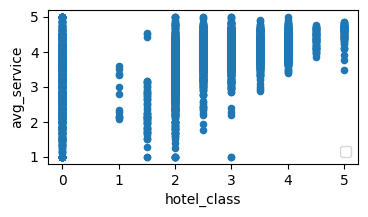

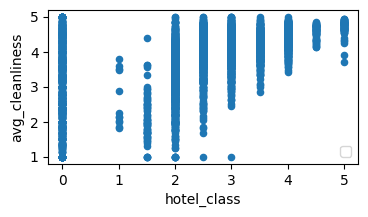

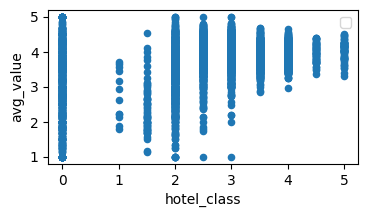

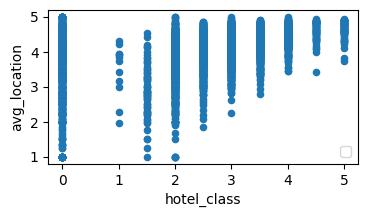

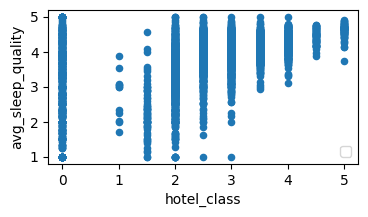

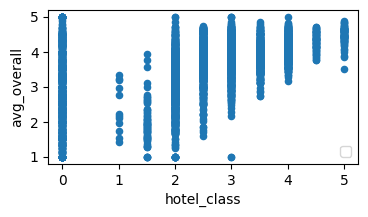

In [14]:
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_service")
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_cleanliness")
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_value")
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_location")
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_sleep_quality")
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_overall")

With an exception for `avg_value` there does seem there is a relationship between the hotel star class and ratings...

## Language Detection

Some of the reviews are in French. Can we detect them and remove them from our dataset to simplify the review summarization? We will use [lingua-py](https://github.com/pemistahl/lingua-py), but other models are available for the same task.

In [15]:
# List of languages to detect:
languages = [Language.ENGLISH, Language.FRENCH]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

In [16]:
def detect_review_langauge(review_title: str, review_text: str, langauge_detector) -> dict:
    """
    For a given String and langauge_detector calculate the detected languages and the confidence scores.
    :param review_title: The title of the review to calculate language detection on.
    :param review_text: The review text to calculate language detection on.
    :param langauge_detector:
    :return: dict with the detected languages and confidence scores.
    """
    detected_scores = {
        "lingua_english": 0.0,
        "lingua_french": 0.0
    }

    # Combine the title and text:
    review_complete = review_title + "\n" + review_text

    confidence_values = langauge_detector.compute_language_confidence_values(review_complete)
    for a_confidence_value in confidence_values:
        if a_confidence_value:
            if Language.ENGLISH == a_confidence_value.language:
                detected_scores["lingua_english"] = a_confidence_value.value
            elif Language.FRENCH == a_confidence_value.language:
                detected_scores["lingua_french"] = a_confidence_value.value
    return detected_scores

In [17]:
# Process the reviews with the language detector:
accommodation_reviews_normalised_df['lingua_scores'] = accommodation_reviews_normalised_df.progress_apply(lambda row: detect_review_langauge(row["title"], row["text"], detector), axis=1)

  0%|          | 0/878561 [00:00<?, ?it/s]

In [19]:
lingua_scores_df = pd.json_normalize(data=accommodation_reviews_normalised_df['lingua_scores'])
accommodation_reviews_languages_df = pd.concat([accommodation_reviews_normalised_df, lingua_scores_df], axis=1)
accommodation_reviews_languages_df.drop(columns="lingua_scores", inplace=True)
accommodation_reviews_languages_df.head()

,id,offering_id,title,text,author,num_helpful_votes,via_mobile,service,cleanliness,value,location,sleep_quality,overall,date_stayed,date,lingua_english,lingua_french
0,147643103,93338,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",0,False,5.0,5.0,5.0,5.0,5.0,5.0,December 2012,2012-12-17,1.0,0.000000e+00
1,147639004,93338,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",0,False,5.0,5.0,5.0,5.0,5.0,5.0,December 2012,2012-12-17,1.0,6.154228e-50
2,147697954,1762573,“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",0,False,4.0,5.0,4.0,5.0,4.0,4.0,December 2012,2012-12-18,1.0,4.028705e-51
3,147625723,1762573,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",0,False,5.0,5.0,5.0,5.0,5.0,4.0,August 2012,2012-12-17,1.0,0.000000e+00
4,147612823,1762573,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",0,False,4.0,5.0,3.0,5.0,5.0,4.0,December 2012,2012-12-17,1.0,0.000000e+00


In [20]:
# Create sub-sets of English and French reviews with a confidence score >= 0.9:
accommodation_reviews_english_df = accommodation_reviews_languages_df.query("lingua_english >= 0.9")
accommodation_reviews_french_df = accommodation_reviews_languages_df.query("lingua_french >= 0.9")

In [21]:
accommodation_reviews_french_df.head()

,id,offering_id,title,text,author,num_helpful_votes,via_mobile,service,cleanliness,value,location,sleep_quality,overall,date_stayed,date,lingua_english,lingua_french
1108,124464068,239853,“Avis partagé”,"les + : Superbes chambres, spacieuses et bien ...","{'username': 'doudou44330', 'num_cities': 5, '...",0,False,4.0,5.0,3.0,5.0,5.0,3.0,February 2012,2012-02-12,6.962404e-48,1.0000
1152,42489303,239853,"“Honorable, correct sans plus”","Un peu loin du centre, mais pas grand chose à ...","{'username': 'lebaroncc', 'num_cities': 11, 'n...",0,False,NaN,NaN,NaN,NaN,NaN,3.0,July 2009,2009-09-17,4.775423e-44,1.0000
1877,69523837,1158926,"“Très bon hotel à Houston, mais à 20 mn du cen...",L'hotel est situé à coté d'un grand axe autoro...,"{'username': 'Voyageur67', 'num_cities': 106, ...",0,False,4.0,5.0,5.0,3.0,5.0,4.0,June 2010,2010-07-03,3.128042e-59,1.0000
2049,146768871,107915,"“Ótima localização, excelente custo/benefício”","O hotel é muito bem localizado, próximo ao Gal...","{'username': 'Mbento_12', 'num_reviews': 8, 'n...",0,False,4.0,5.0,4.0,5.0,5.0,4.0,November 2012,2012-12-04,0.000000e+00,1.0000
2050,123681828,107915,“Drury inn galería houston”,"La atención excelente, la habitación cómoda, d...","{'username': '', 'id': '', 'location': ''}",0,False,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2012-01-24,7.550023e-02,0.9245


In [22]:
accommodation_reviews_english_df.head()

,id,offering_id,title,text,author,num_helpful_votes,via_mobile,service,cleanliness,value,location,sleep_quality,overall,date_stayed,date,lingua_english,lingua_french
0,147643103,93338,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",0,False,5.0,5.0,5.0,5.0,5.0,5.0,December 2012,2012-12-17,1.0,0.000000e+00
1,147639004,93338,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",0,False,5.0,5.0,5.0,5.0,5.0,5.0,December 2012,2012-12-17,1.0,6.154228e-50
2,147697954,1762573,“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",0,False,4.0,5.0,4.0,5.0,4.0,4.0,December 2012,2012-12-18,1.0,4.028705e-51
3,147625723,1762573,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",0,False,5.0,5.0,5.0,5.0,5.0,4.0,August 2012,2012-12-17,1.0,0.000000e+00
4,147612823,1762573,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",0,False,4.0,5.0,3.0,5.0,5.0,4.0,December 2012,2012-12-17,1.0,0.000000e+00


In [23]:
# What reviews have neither a high English or French confidence score?
accommodation_reviews_neither_df = accommodation_reviews_languages_df.query("lingua_english < 0.9 & lingua_french < 0.9")

In [24]:
accommodation_reviews_neither_df.head()

,id,offering_id,title,text,author,num_helpful_votes,via_mobile,service,cleanliness,value,location,sleep_quality,overall,date_stayed,date,lingua_english,lingua_french
1066,146283077,239853,“Im Schatten der Wolkenkratzer!”,Optimaler Aufenthalt für 3 Tage! Traumhaftes B...,"{'username': 'Stefan K', 'num_cities': 12, 'nu...",0,False,5.0,5.0,4.0,5.0,5.0,5.0,November 2012,2012-11-27,0.189751,0.810249
2715,135604716,223137,“とにかく遠い”,ヒューストンのダウンタウンからは車で30分以上かかります。ハイウェイ沿いにあるので、車で移動...,"{'username': 'Aya1231', 'num_cities': 12, 'num...",0,False,3.0,2.0,3.0,2.0,3.0,2.0,August 2011,2012-07-28,0.000000,0.000000
3837,136343075,223151,“Muy buen hotel”,"El hotel es muy bonito, desayuno excelente! El...","{'username': 'Ducklover7', 'num_cities': 7, 'n...",0,False,3.0,5.0,5.0,5.0,NaN,5.0,July 2012,2012-08-05,0.766544,0.233456
4355,23680833,99081,“乗り継ぎ利用時は疲れますが・・・快適でした”,出張時の乗継時に一泊利用。乗り継ぎ時の利用は時差ぼけ等々でいつも相当に疲れますし、入国スタン...,"{'username': 'PUR014', 'num_cities': 29, 'num_...",0,False,4.0,5.0,3.0,3.0,NaN,4.0,October 2008,2009-01-19,0.000000,0.000000
4514,144981861,98952,“素晴らしい”,設備、サービスともに良かった。\n石鹸、シャンプーなどのバスアメニティは全てロクシタン。\n...,"{'username': 'AMDW161', 'num_cities': 24, 'num...",0,False,4.0,5.0,5.0,5.0,5.0,5.0,October 2012,2012-11-09,0.000000,0.000000


In [25]:
# Dataset sizes:
print(f"English review dataset: {len(accommodation_reviews_english_df)}")
print(f"French review dataset: {len(accommodation_reviews_french_df)}")
print(f"Neither English or French review dataset: {len(accommodation_reviews_neither_df)}")

English review dataset: 834492
French review dataset: 33009
Neither English or French review dataset: 11060


 ## Future Work:

* Explore different models and how they compare to `py-lingua` in terms of language identification such as the [xlm-roberta-base-language-detection](https://huggingface.co/papluca/xlm-roberta-base-language-detection) model on HuggingFace.
* Do users who write reviews in different languages have different ratings for the same given accommodation?

## English Review Length & Sentiment Analysis

Let's focus for now on the English reviews now and understand the types of reviews that we have. In particular, how long are the reviews and what is the user sentiment in the reviews written. Does the sentiment correlate with the review scores given?

In [36]:
# Setup NLTK:
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt_tab')
nltk.download("popular")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package inaugural is already up-t

True

In [35]:
# Compute review text token lengths:
accommodation_reviews_english_df["review_length"] = accommodation_reviews_english_df.progress_apply(lambda row: len(word_tokenize(row["text"])), axis=1)
accommodation_reviews_english_df.head()

  0%|          | 0/834492 [00:00<?, ?it/s]

,id,offering_id,title,text,author,num_helpful_votes,via_mobile,service,cleanliness,value,location,sleep_quality,overall,date_stayed,date,lingua_english,lingua_french,review_length
0,147643103,93338,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",0,False,5.0,5.0,5.0,5.0,5.0,5.0,December 2012,2012-12-17,1.0,0.000000e+00,215
1,147639004,93338,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",0,False,5.0,5.0,5.0,5.0,5.0,5.0,December 2012,2012-12-17,1.0,6.154228e-50,86
2,147697954,1762573,“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",0,False,4.0,5.0,4.0,5.0,4.0,4.0,December 2012,2012-12-18,1.0,4.028705e-51,105
3,147625723,1762573,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",0,False,5.0,5.0,5.0,5.0,5.0,4.0,August 2012,2012-12-17,1.0,0.000000e+00,300
4,147612823,1762573,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",0,False,4.0,5.0,3.0,5.0,5.0,4.0,December 2012,2012-12-17,1.0,0.000000e+00,560


In [37]:
# Use the pre-trained VADER (Valence Aware Dictionary and sEntiment Reasoner) to classify the reviews:
sentiment_analyzer = SentimentIntensityAnalyzer()
accommodation_reviews_english_df["sentiment_scores"] = accommodation_reviews_english_df.progress_apply(lambda row: sentiment_analyzer.polarity_scores(row["text"]), axis=1)
accommodation_reviews_english_df.head()

  0%|          | 0/834492 [00:00<?, ?it/s]

,id,offering_id,title,text,author,num_helpful_votes,via_mobile,service,cleanliness,value,location,sleep_quality,overall,date_stayed,date,lingua_english,lingua_french,review_length,sentiment_scores
0,147643103,93338,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",0,False,5.0,5.0,5.0,5.0,5.0,5.0,December 2012,2012-12-17,1.0,0.000000e+00,215,"{'neg': 0.013, 'neu': 0.718, 'pos': 0.269, 'co..."
1,147639004,93338,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",0,False,5.0,5.0,5.0,5.0,5.0,5.0,December 2012,2012-12-17,1.0,6.154228e-50,86,"{'neg': 0.0, 'neu': 0.74, 'pos': 0.26, 'compou..."
2,147697954,1762573,“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",0,False,4.0,5.0,4.0,5.0,4.0,4.0,December 2012,2012-12-18,1.0,4.028705e-51,105,"{'neg': 0.017, 'neu': 0.783, 'pos': 0.201, 'co..."
3,147625723,1762573,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",0,False,5.0,5.0,5.0,5.0,5.0,4.0,August 2012,2012-12-17,1.0,0.000000e+00,300,"{'neg': 0.02, 'neu': 0.851, 'pos': 0.129, 'com..."
4,147612823,1762573,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",0,False,4.0,5.0,3.0,5.0,5.0,4.0,December 2012,2012-12-17,1.0,0.000000e+00,560,"{'neg': 0.077, 'neu': 0.752, 'pos': 0.171, 'co..."


In [38]:
sentiment_scores_df = pd.json_normalize(data=accommodation_reviews_english_df['sentiment_scores'])
accommodation_reviews_english_df = pd.concat([accommodation_reviews_english_df, sentiment_scores_df], axis=1)
accommodation_reviews_english_df.drop(columns="sentiment_scores", inplace=True)
accommodation_reviews_english_df.head()

,id,offering_id,title,text,author,num_helpful_votes,via_mobile,service,cleanliness,value,...,overall,date_stayed,date,lingua_english,lingua_french,review_length,neg,neu,pos,compound
0,147643103.0,93338.0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",0.0,False,5.0,5.0,5.0,...,5.0,December 2012,2012-12-17,1.0,0.000000e+00,215.0,0.013,0.718,0.269,0.9966
1,147639004.0,93338.0,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",0.0,False,5.0,5.0,5.0,...,5.0,December 2012,2012-12-17,1.0,6.154228e-50,86.0,0.000,0.740,0.260,0.9783
2,147697954.0,1762573.0,“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",0.0,False,4.0,5.0,4.0,...,4.0,December 2012,2012-12-18,1.0,4.028705e-51,105.0,0.017,0.783,0.201,0.9726
3,147625723.0,1762573.0,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",0.0,False,5.0,5.0,5.0,...,4.0,August 2012,2012-12-17,1.0,0.000000e+00,300.0,0.020,0.851,0.129,0.9632
4,147612823.0,1762573.0,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",0.0,False,4.0,5.0,3.0,...,4.0,December 2012,2012-12-17,1.0,0.000000e+00,560.0,0.077,0.752,0.171,0.9934


In [39]:
# Save intermediate data to CSV:
accommodation_reviews_english_df.to_csv("./resources/data/intermediate/accommodation_reviews_english.csv", index=False)

In [ ]:
# Load data [Optional]:
accommodation_reviews_english_df = pd.read_csv("./resources/data/intermediate/accommodation_reviews_english.csv")

In [40]:
# What are the top-10 most positive reviews?
accommodation_reviews_english_df.sort_values(by="pos", ascending=False).head(10)

,id,offering_id,title,text,author,num_helpful_votes,via_mobile,service,cleanliness,value,...,overall,date_stayed,date,lingua_english,lingua_french,review_length,neg,neu,pos,compound
374444,38415441.0,638765.0,“Perfect (if you have a car)”,We were lucky enough to get our 3 night stay f...,"{'username': 'Hooleybooley', 'num_cities': 6, ...",0.0,False,5.0,5.0,3.0,...,4.0,August 2009,2009-08-21,1.000000,0.000000e+00,204.0,0.0,0.047,0.953,0.9601
659691,140842014.0,1675976.0,“Weekend getaway with the kidos”,I took my two children for a short getaway and...,"{'username': 'scott s', 'num_reviews': 1, 'id'...",0.0,False,5.0,5.0,5.0,...,5.0,September 2012,2012-09-21,1.000000,1.684759e-40,85.0,0.0,0.095,0.905,0.8591
822609,129727113.0,308759.0,“Very nice”,I stayed there with my family for two days. Th...,"{'username': 'Carlos F', 'num_cities': 15, 'nu...",0.0,False,4.0,5.0,4.0,...,4.0,December 2011,2012-05-10,0.999484,5.159882e-04,27.0,0.0,0.115,0.885,0.9466
2463,122717256.0,1641016.0,“Wonderful Stay at The Chatwal!”,My wife and I stayed at The Chatwal in the mid...,"{'username': 'BlakeTraveler', 'num_cities': 8,...",0.0,False,5.0,5.0,5.0,...,5.0,December 2011,2012-01-07,1.000000,0.000000e+00,694.0,0.0,0.126,0.874,0.9312
325588,46980102.0,1235890.0,“Loved it”,Stayed for two night for chicago marathon in o...,"{'username': 'marathonmanjax', 'num_cities': 1...",2.0,False,4.0,4.0,4.0,...,5.0,October 2009,2009-10-16,1.000000,3.503658e-76,189.0,0.0,0.132,0.868,0.9628
308609,137174736.0,2648906.0,“Needs some kinks worked out”,We stayed here on a Saturday night at the end ...,"{'username': 'chicagolefty', 'num_cities': 9, ...",0.0,False,2.0,5.0,3.0,...,3.0,July 2012,2012-08-14,1.000000,0.000000e+00,321.0,0.0,0.132,0.868,0.9669
697820,82129617.0,1526953.0,“Worst Customer Service”,We made reservations for Monday through Wednes...,"{'username': 'pnutsdog', 'num_reviews': 1, 'id...",4.0,False,NaN,NaN,NaN,...,1.0,September 2010,2010-10-05,1.000000,6.888647e-83,156.0,0.0,0.135,0.865,0.9646
534141,146226943.0,109334.0,“Great overall experience”,We were here during the Thanksgiving weekend. ...,"{'username': '2yun2write', 'num_cities': 9, 'n...",0.0,False,3.0,4.0,4.0,...,4.0,November 2012,2012-11-26,1.000000,1.230693e-86,198.0,0.0,0.136,0.864,0.9684
14433,140724681.0,99007.0,“Nice by the airport”,I stayed here for a quick overnight stay befor...,"{'username': 'annoddddd', 'num_cities': 45, 'n...",0.0,False,4.0,4.0,4.0,...,4.0,September 2012,2012-09-19,1.000000,3.396564e-50,77.0,0.0,0.137,0.863,0.9637
682133,119403671.0,100511.0,"“Brand new, beautiful, and friendly”",We stayed one night on the way back from a wee...,"{'username': 'cb-arlington', 'num_cities': 2, ...",1.0,True,5.0,5.0,5.0,...,5.0,October 2011,2011-10-17,1.000000,1.842051e-79,99.0,0.0,0.147,0.853,0.9468


<Axes: xlabel='pos', ylabel='review_length'>

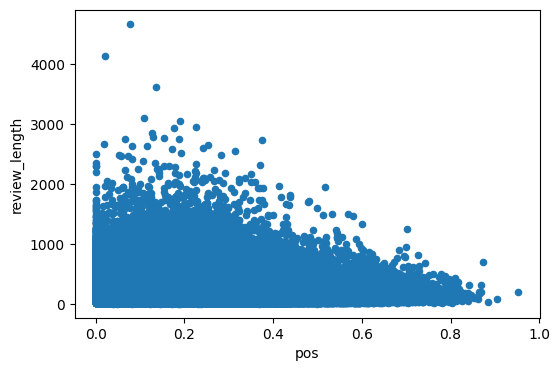

In [44]:
# Is there any relationship between review length and positive sentiment:
accommodation_reviews_english_df.plot.scatter(figsize=(6, 4), x="pos", y="review_length")

In [45]:
# What about with hotel class?
accommodation_offerings_df["avg_review_length"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"], "review_length",
                                                                                                                               accommodation_reviews_english_df), axis=1)
accommodation_offerings_df["avg_neg"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"], "neg",
                                                                                                                               accommodation_reviews_english_df), axis=1)
accommodation_offerings_df["avg_neu"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"], "neu",
                                                                                                                     accommodation_reviews_english_df), axis=1)
accommodation_offerings_df["avg_pos"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"], "pos",
                                                                                                                     accommodation_reviews_english_df), axis=1)
accommodation_offerings_df["avg_compound"] = accommodation_offerings_df.progress_apply(lambda row: compute_average_scores(row["id"], "compound",
                                                                                                                     accommodation_reviews_english_df), axis=1)
accommodation_offerings_df.head()

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

  0%|          | 0/4333 [00:00<?, ?it/s]

,id,name,type,hotel_class,address,avg_service,avg_cleanliness,avg_value,avg_location,avg_sleep_quality,avg_overall,avg_review_length,avg_neg,avg_neu,avg_pos,avg_compound
0,113317,Casablanca Hotel Times Square,hotel,4.0,"{'region': 'NY', 'street-address': '147 West 4...",4.833333,4.826730,4.480420,4.900482,4.513158,4.735470,164.435051,0.032312,0.767196,0.200491,0.780740
1,76049,Four Seasons Hotel Los Angeles at Beverly Hills,hotel,5.0,"{'region': 'CA', 'street-address': '300 S Dohe...",4.726351,4.748299,4.159322,4.604743,4.681223,4.575301,158.949686,0.040311,0.785943,0.173723,0.693677
2,99352,Hilton Garden Inn Times Square,hotel,3.5,"{'region': 'NY', 'street-address': '790 Eighth...",4.508995,4.613228,4.338803,4.819776,4.505417,4.490026,156.740008,0.038239,0.781974,0.179799,0.695288
3,93589,The Michelangelo Hotel,hotel,4.0,"{'region': 'NY', 'street-address': '152 West 5...",4.470192,4.707411,4.256809,4.866438,4.657321,4.532688,149.397976,0.032339,0.777691,0.189950,0.735852
4,217616,The Muse Hotel New York,hotel,4.0,"{'region': 'NY', 'street-address': '130 West 4...",4.419293,4.598854,4.111111,4.791295,4.423547,4.425532,168.934603,0.031337,0.777149,0.191512,0.759164


array([<Axes: xlabel='hotel_class', ylabel='avg_compound'>], dtype=object)

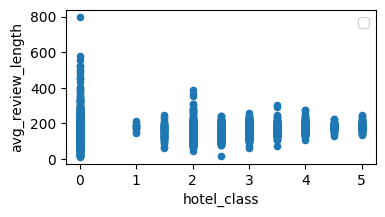

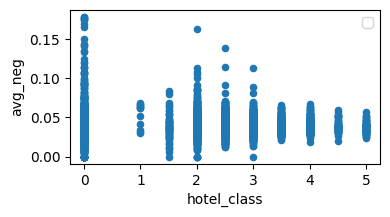

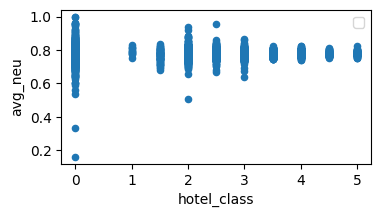

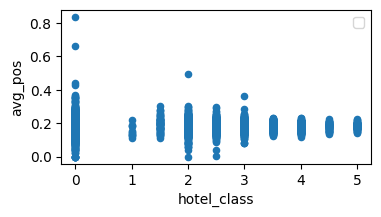

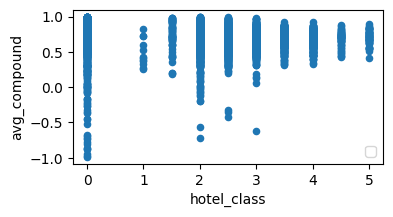

In [46]:
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_review_length")
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_neg")
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_neu")
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_pos")
accommodation_offerings_df.plot.scatter(subplots=True, figsize=(4, 2), x="hotel_class", y="avg_compound")

## Review Summarization

From the above we can select the most positive five reviews for each accommodation and prompt a model to summarise the given reviews with a focus on the most relevant points. Consider experimenting with the prompt and what reviews should be given to model for summarization. In addition, the default prompt is a zero shot prompt. Would examples in the prompt help? Try using an LLM to generate the prompt for you.

Before running this section ensure that ollama is up by running: `ollama serve`

For this section we will use [Llama 3.1-8b](https://ollama.com/library/llama3.1) as our model of choice. Feel free to experiment with other models.

In [71]:
def generate_ollama_response(content: str, language_model="llama3.1") -> str:
    response: ChatResponse = chat(model=language_model, messages=[
        {
            'role': 'user',
            'content': content,
        },
    ])
    return response['message']['content']

In [67]:
print(generate_ollama_response("Hello!"))

Hello! How are you today? Is there something I can help you with, or would you like to chat?


In [74]:
# Load the default prompt -- This prompt was generated by Llama 3.1:
default_prompt_template = open("./resources/data/prompt/default_prompt.txt").read()

In [80]:
def generate_positive_review_summary(prompt_template: str, offering_id: int, reviews_dataset_df: DataFrame) -> str:
    # Get all reviews for the given accommodation ID:
    accommodation_reviews_df = reviews_dataset_df.loc[reviews_dataset_df["offering_id"] == offering_id]
    accommodation_reviews_df = accommodation_reviews_df.sort_values(by=["pos"], ascending=False).head(5)
    accommodation_reviews_list = accommodation_reviews_df["text"].tolist()
    prompt_rendered = prompt_template
    for i in range(0, len(accommodation_reviews_list)):
        prompt_rendered = prompt_rendered.replace("{{ review_" + str(i) + " }}", accommodation_reviews_list[i])
    return generate_ollama_response(prompt_rendered)

In [81]:
# Select a random hotel and generate some review summaries -- Speed will depend on compute power
# e.g. GPU, CPU, and RAM for inferencing (reference: 2017 Macbook Pro - CPU: 2.8Ghz Quad-core i7 (Kabylake), 16GB RAM: ~5 minutes)
# Supported GPUs can be found here: https://ollama.readthedocs.io/en/gpu/
random_accommodations_df = accommodation_offerings_df.sample(n=1)
random_accommodations_df["review_summaries"] = random_accommodations_df.progress_apply(lambda row: generate_positive_review_summary(
    prompt_template=default_prompt_template,
    offering_id=row["id"],
    reviews_dataset_df=accommodation_reviews_english_df
), axis=1)
random_accommodations_df.head()

  0%|          | 0/1 [00:00<?, ?it/s]

,id,name,type,hotel_class,address,avg_service,avg_cleanliness,avg_value,avg_location,avg_sleep_quality,avg_overall,avg_review_length,avg_neg,avg_neu,avg_pos,avg_compound,review_summaries
4225,120613,Four Points by Sheraton,hotel,3.0,"{'region': 'DC', 'street-address': '1201 K St....",3.821053,3.863158,3.525333,4.217523,3.81323,3.527716,176.918605,0.033268,0.759946,0.206819,0.702554,Here is a JSON structure summarizing the top 3...


In [82]:
print(random_accommodations_df.iloc[0]["review_summaries"])

'Here is a JSON structure summarizing the top 3 strengths of this hotel based on guest reviews:\n\n[\n    {\n        "title": "Convenient Location and Friendly Staff",\n        "summary": "Guests rave about the hotel\'s prime location near public transportation, including the Circulator bus and Metro train station. The staff, particularly Barbara at the front desk, are consistently praised for their friendliness and helpfulness. One reviewer even credited Barbara with choosing this hotel over others due to her exceptional service."\n    },\n    {\n        "title": "Clean and Comfortable Rooms",\n        "summary": "Reviewers appreciate the hotel\'s clean and well-maintained rooms, which feature comfy beds and modern amenities. Some guests mention that the rooms are a bit small, but overall, they\'re satisfied with the accommodations. One reviewer even mentions that the staff quickly addressed an issue with mice in their room."\n    },\n    {\n        "title": "Personalized Service and 

## Conclusion

In this tutorial we have explored the end-to-end process from data analysis, enrichment, and summarization. For additional challenges consider what changes you would make in terms of:

* What additional analyses would do to the data that was not done in this notebook?
* What other data enrichment would you consider for the base dataset (e.g. external geospatial data, part-of-speech tagging, etc.)?
* How would change the way the model is prompted to generate the summaries from the reviews?
* In terms of non-English languages, what approaches would you consider?
* Evaluation: How would evaluate the accuracy and appropriateness of the text generated by the model?